# Monte Carlo Pricing of a Spread Option and Its Greeks

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
S1 = 100
S2 = 90
K = 8
T = 1
r = 0.05
sigma1 = 0.2
sigma2 = 0.3
rho = 0.5
N = 252 
num_simulations = 100000
epsilon = 30

In [3]:
def monte_carlo_spread_option_greeks(S1, S2, K, T, r, sigma1, sigma2, rho, N, num_simulations, epsilon):
    dt = T / N
    discount_factor = np.exp(-r * T) 

    F1 = S1 * np.exp(r * T)
    F2 = S2 * np.exp(r * T)
    drift1 = np.log(F1 / S1) / T
    drift2 = np.log(F2 / S2) / T

    def generate_paths(S1_init, S2_init):
        paths1 = np.zeros((num_simulations, N + 1))
        paths2 = np.zeros((num_simulations, N + 1))
        paths1[:, 0] = S1_init
        paths2[:, 0] = S2_init

        for i in range(1, N + 1):
            dW1 = np.random.normal(0, np.sqrt(dt), num_simulations)
            dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), num_simulations)

            paths1[:, i] = paths1[:, i - 1] * np.exp((drift1 - 0.5 * sigma1**2) * dt + sigma1 * dW1)
            paths2[:, i] = paths2[:, i - 1] * np.exp((drift2 - 0.5 * sigma2**2) * dt + sigma2 * dW2)

        return paths1[:, -1], paths2[:, -1]

    S1_paths, S2_paths = generate_paths(S1, S2)
    payoffs = np.maximum(S1_paths - S2_paths - K, 0)
    price = np.mean(payoffs) * discount_factor

    S1_up_paths, S2_paths = generate_paths(S1 + epsilon, S2)
    S1_down_paths, _ = generate_paths(S1 - epsilon, S2)
    _, S2_up_paths = generate_paths(S1, S2 + epsilon)
    _, S2_down_paths = generate_paths(S1, S2 - epsilon)

    payoffs_up_S1 = np.maximum(S1_up_paths - S2_paths - K, 0)
    payoffs_down_S1 = np.maximum(S1_down_paths - S2_paths - K, 0)
    payoffs_up_S2 = np.maximum(S1_paths - S2_up_paths - K, 0)
    payoffs_down_S2 = np.maximum(S1_paths - S2_down_paths - K, 0)

    price_up_S1 = np.mean(payoffs_up_S1) 
    price_down_S1 = np.mean(payoffs_down_S1) 
    price_up_S2 = np.mean(payoffs_up_S2) 
    price_down_S2 = np.mean(payoffs_down_S2)

    delta_S1 = (price_up_S1 - price_down_S1) / (2 * epsilon)
    delta_S2 = (price_up_S2 - price_down_S2) / (2 * epsilon)
    gamma_S1 = (price_up_S1 - 2 * price + price_down_S1) / (epsilon**2)
    gamma_S2 = (price_up_S2 - 2 * price + price_down_S2) / (epsilon**2)

    T_short = T - dt
    S1_paths_T, S2_paths_T = generate_paths(S1, S2)
    payoffs_T = np.maximum(S1_paths_T - S2_paths_T - K, 0)
    price_T = np.mean(payoffs_T) * np.exp(-r * T_short)
    theta = (price-price_T) / (dt)

    return price, delta_S1, gamma_S1, delta_S2, gamma_S2, theta


price, delta_S1, gamma_S1, delta_S2, gamma_S2, theta = monte_carlo_spread_option_greeks(S1, S2, K, T, r, sigma1, sigma2, rho, N, num_simulations, epsilon)
print(f"Price: {price:.4f}, Delta S1: {delta_S1:.4f}, Gamma S1: {gamma_S1:.4f}, Delta S2: {delta_S2:.4f}, Gamma S2: {gamma_S2:.4f}, Theta: {theta:.4f}")


Price: 10.9578, Delta S1: 0.5573, Gamma S1: 0.0183, Delta S2: -0.5001, Gamma S2: 0.0216, Theta: -0.0353


# Plotting Price Changes with Different Correlations

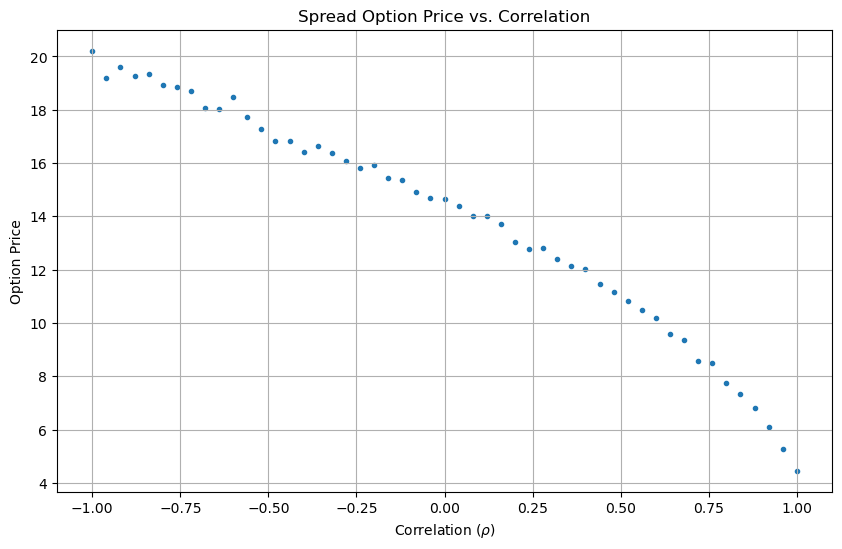

In [4]:
def simulate_spread_option_price(S1, S2, K, T, r, sigma1, sigma2, rho, N, num_simulations):
    dt = T / N
    paths1 = np.zeros(num_simulations)
    paths2 = np.zeros(num_simulations)
    paths1[:] = S1
    paths2[:] = S2

    for _ in range(N):
        dW1 = np.random.normal(0, np.sqrt(dt), num_simulations)
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), num_simulations)
        paths1 *= np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * dW1)
        paths2 *= np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * dW2)

    payoffs = np.maximum(paths1 - paths2 - K, 0)
    price = np.mean(payoffs) * np.exp(-r * T)
    return price

S1 = 100
S2 = 90
K = 8
T = 1
r = 0.05
sigma1 = 0.2
sigma2 = 0.3
N = 1000
num_simulations = 10000

rhos = np.linspace(-1, 1, 51)
prices = []

for rho in rhos:
    price = simulate_spread_option_price(S1, S2, K, T, r, sigma1, sigma2, rho, N, num_simulations)
    prices.append(price)

plt.figure(figsize=(10, 6))
plt.scatter(rhos, prices, marker='.')
plt.title('Spread Option Price vs. Correlation')
plt.xlabel('Correlation ($\\rho$)')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


# Intuitive Explanation:

The graph exhibits a downward trend, indicating that as the correlation between the two underlying assets increases, the price of the spread option decreases.


1. **Effect of Correlation**:
   - **High Positive Correlation**: When the correlation is close to +1, the two assets tend to move together very closely. This movement reduces the volatility of the difference between the two asset prices (i.e., the spread), making it less likely that the spread will exceed the strike price $K$ by a significant margin. Thus, the option's value (which depends on the spread being larger than $K$) is lower.
   - **Low or Negative Correlation**: When the correlation is low or negative, the assets are less synchronized in their movements, increasing the volatility of the spread. This increased volatility enhances the probability that the spread will deviate significantly from zero, either above or below, thereby increasing the chances that the spread will exceed the strike price $K$ and hence increasing the value of the option.

2. **Interpreting the Graph**:
   - The graph shows that as correlation increases from -1 to 1, the option price decreases, reflecting the reduced uncertainty (or risk) in the spread exceeding the strike price when the assets move more in tandem.
   - At lower correlations, especially negative correlations, the spread's uncertainty is higher, enhancing the option's value due to the greater probability of significant deviations between the two asset prices.